# This notebook is devoted to studying the portfolio optimization library in Qiskit


In [1]:
!pip install qiskit-finance

In [2]:
import qiskit_finance
#import qiskit_algorithms
#from qiskit.circuit.library import TwoLocal
#from qiskit.result import QuasiDistribution
#from qiskit_aer.primitives import Sampler
#from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
#from qiskit_algorithms.optimizers import COBYLA
#from qiskit_finance.applications.optimization import PortfolioOptimization
#from qiskit_finance.data_providers import RandomDataProvider
#from qiskit_optimization.algorithms import MinimumEigenOptimizer
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [15]:
from qiskit_finance.data_providers import RandomDataProvider
num_assets = 4
seed = 1

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2016, 1, 1),
    end=datetime.datetime(2016, 1, 30),
    seed=seed,
)
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()
cc = data.get_coordinates()

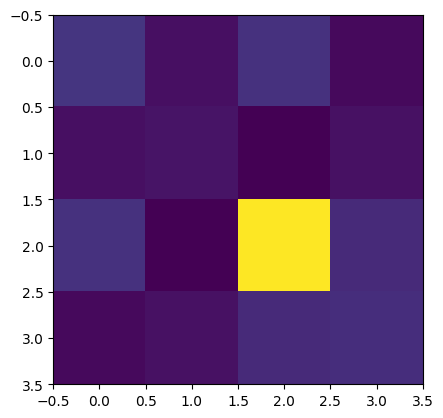

In [16]:
plt.imshow(sigma, interpolation="nearest")
plt.show()

In [17]:
from qiskit_finance.applications.optimization import PortfolioOptimization
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.00031589664798388565*x_0^2 + 2.6555628489113036e..., 4 variables, 1 constraints, 'Portfolio optimization'>

In [18]:
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

In [19]:
pip install qiskit_algorithms

Note: you may need to restart the kernel to use updated packages.


In [20]:
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.result import QuasiDistribution

exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [0. 1. 0. 1.], value -0.0001

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 0 1]	-0.0001		1.0000


In [21]:
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import Sampler

algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
svqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
svqe = MinimumEigenOptimizer(svqe_mes)
result = svqe.solve(qp)

print_result(result)

Optimal: selection [0. 1. 0. 1.], value -0.0001

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 0 1]	0.0029		0.9473
 [0 0 1 1]	0.0129		0.0176
 [1 1 0 0]	0.0026		0.0117
 [0 1 1 0]	0.0120		0.0088
 [0 0 0 1]	0.0001		0.0068
 [1 1 0 1]	0.0027		0.0039
 [0 1 0 1]	-0.0001		0.0010
 [1 0 0 0]	0.0028		0.0010
 [1 1 1 0]	0.0154		0.0010
 [1 0 1 1]	0.0163		0.0010


In [14]:
result


<MinimumEigenOptimizationResult: fval=-0.01488461311339271, x_0=1.0, x_1=0.0, x_2=0.0, x_3=1.0, status=SUCCESS>